**Note:** This notebook is written in the Julia language, so the cells can't be
  executed in Google Colab. If you want to verify that the notebook works, I
  recommend [JuliaBox](https://juliabox.com/) or testing locally. The syntax is
  very similar to Python and MATLAB. Note in particular the dot syntax used to
  perform elementwise operations ( `f.(x)` applies `f` to all elements of `x` ),
  that indices start at 1 and that the last statement of all functions is returned
  automatically.

# **Lab 6: Partial Differential Equations**
**Anders Ågren Thuné**

# **Abstract**

This report presents how the finite element method was implemented to solve the Poisson
equation in 1 and 2 dimensions.

# **About the code**

In [1]:
"""
DD2363 Methods in Scientific Computing,
KTH Royal Institute of Technology, Stockholm, Sweden.
"""

# Copyright (C) 2019
# Anders Ågren Thuné (athune@kth.se)
# Johan Hoffman (jhoffman@kth.se)

# Code written by Anders Ågren Thuné based on the template by Johan Hoffman.

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

"DD2363 Methods in Scientific Computing,\nKTH Royal Institute of Technology, Stockholm, Sweden.\n"

# **Set up environment**

In [3]:
using LinearAlgebra
using Plots
pyplot()

Plots.PyPlotBackend()

# **Introduction**

As we've seen, time stepping methods are useful for modelling a wide variety of
different initial value problems involving ordinary differential equations and
systems of them. However, these models only take a single parameter into
account, so if we wanted to perform a simulation over some 2-dimensional space
with some property depending on both the $x$ and the $y$ value, for instance,
we'd be out of luck. A differential equation involving several independent
variables is called a partial differential equation. A common problem is where
some partial differential equation involving $u$, a function of multiple
variables, is given along with some boundary condition, for instance $u = 0$
along the boundary. In order to solve these, a different approach needs to be taken.

This report presents how the finite element method, a powerful tool for solving
partial differential equations, was implemented and used for solving the boundary value
problem described by the Poisson equation. First, the method and its
implementation in the Julia language is presented, followed by tests and
visualizations verifying the accuracy of the implementation.

# **Methods**

### **The finite element method**

The finite element method is used to solve partial differential equations, and in
particular boundary value problems. The finite element method is a Galerkin
method based on the exact same principles as $L^2$-projection, which we
implemented in Lab 4. However, when solving a boundary value problem, we are no
longer solving for $Pf$ such that $(Pf, v) = (f, v) \forall v \in V$ for some
space $V$, but rather seeking $U$ such that $a(U,v) = L(v) \forall v \in V$,
where $a$ is a bilinear form and $L$ is a linear form. We see that this is a
generalization of the $L^2$-projection, which uses $a(u, v) = (u, v), \quad L(v)
= (f, v)$. For instance, we can show that setting $a(u, v) = (\nabla u, \nabla
v), L(v) = (f, v)$ and solving for $U$ leads to an optimal solution to the
boundary value problem $$\left\{ \begin{array} -\Delta u = f, & \text{in}\ \Omega
\\ u = 0, & \text{on}\ \delta\Omega\end{array} \right.$$ known as the Poisson
equation. In practice, this only results in a slight difference in the assembly
algorithm, where we have $M_{ij}^k = (\lambda'_i, \lambda'_j)$ in the
one-dimensional case, and $M_{ij}^k = (\nabla \lambda_i, \nabla \lambda_j)$ in
the higher-dimensional case.

#### **Code from previous labs**

As we still need to calculate the relevant integrals in the 2d-case, the following code
is reused from Lab 4.

In [1]:
"""
  A function for computing the integral of the triangle with vertices xs[:,1], xs[:,2],
  xs[:,3] using a one-point Gaussian quadrature rule. The function uses an affine map
  Fk = Mx + b to translate the midpoint of the reference triangle to the given triangle
  and compute the integral.
"""
function gq_2d(f, xs)
    M = [-xs[1,1]+xs[1,2] -xs[1,1]+xs[1,3];
         -xs[2,1]+xs[2,2] -xs[2,1]+xs[2,3]]
    b = xs[:,1]

    det(M)*f( M*[1/3,1/3] + b )/2
end

gq_2d

#### **1d FEM Poisson boundary problem solver**

The code is practically the same as for lab 4, but the elements of the mass
matrix need to be updated correctly according to the new rule. Calculating the
derivatives of the Lagrange basis functions, we get: $$\lambda'_{i, 1} =
\frac{d}{dx}\frac{x-x_{i-1}}{h_i} = \frac{1}{h_i},$$ $$\lambda'_{i+1, 0} =
\frac{d}{dx}\frac{x_{i+1}-x}{h_{i+1}} = \frac{-1}{h_{i+1}}$$ Plugging into the
formulae, we get $$M_{ii} = (\lambda'_i, \lambda'_i) = \int_{I_{i+1}} \lambda_{i,1}^{\prime 2} + \lambda_{i+1,0}^{\prime 2} dx = \int_{x_{i-1}}^{x_i}
\frac{1}{h_i^2} dx + \int_{x_i}^{x_{i+1}} \frac{1}{h_{i+1}^2} dx = \frac{1}{h_i}
+ \frac{1}{h_{i+1}}$$ Similarly, we have $$M_{ii+1} = (\lambda'_i,
\lambda'_{i+1}) = \int_{I_{i+1}} \lambda'_{i+1,0} \lambda'_{i+1,1} dx =
\int_{I_{i+1}} \frac{-1}{h_{i+1}^2} dx = \frac{-1}{h_{i+1}}$$
We also need to take into consideration that the boundary values should be zero,
meaning we should loop through a smaller interval when filling in the matrix.

In [2]:
"""
  Compute the vector U = {U(xᵢ)}, containing the approximate solution to the problem
  u'' = -f, u₀ = uₙ = 0, with mesh = {xᵢ}.
"""
function fem_1d(f, mesh)
    m = length(mesh)
    b = zeros(m)
    M = zeros(m,m)
    h = diff(mesh)

    M[2,2] = 1/h[2]
    b[2] += f(mesh[2])*h[2]/2
    M[end-1,end-1] = 1/h[end-1]
    b[end-1] += f(mesh[end-1])*h[end-2]/2
    for i in 2:m-2
        b[i] += f(mesh[i])*h[i]/2
        b[i+1] += f(mesh[i+1])*h[i]/2

        M[i,i] += 1/h[i]
        M[i,i+1] -= 1/h[i]
        M[i+1,i] -= 1/h[i]
        M[i+1,i+1] += 1/h[i]
    end

    pinv(M)*b # for some reason the \ operator would give me a SingularException...
end

fem_1d

#### **2d FEM Poisson boundary problem solver**

Here, the inner product $(\lambda_i, \lambda_j)$ should change to $(\nabla
\lambda_i, \nabla \lambda_j)$. Computing the derivatives of the basis functions
on the reference triangle, we obtain
$$ \nabla \lambda_1 = \nabla (1 - x - y) = \left[\begin{array} x-1 \\ -1 \end{array}\right]$$
$$ \nabla \lambda_2 = \nabla (x) = \left[\begin{array} x1 \\ 0 \end{array}\right]$$
$$ \nabla \lambda_3 = \nabla (y) = \left[\begin{array} x0 \\ 1 \end{array}\right]$$
We can then call the quadrature function with the relevant constants and let it map the
result to the current triangle, which we then sum to obtain the dot product.

In [53]:
"""
  An array containing the values of ∇λᵢ for the reference triangle.
"""
const ∇λ = [-1. -1.;
             1.  0.;
             0.  1.]

"""
  Compute the vector U = {U(xᵢ)}, containing the coefficients used to approximate the solution
  to the problem Δu = -f in Ω, u = 0 on δΩ. The parameters vertices and elements describe
  the mesh: vertices contains x and y coordinates of the nodes in the mesh and elements
  contains one row for each element in the mesh, each entry being the index of a vertex
  node of the element. The boundary parameter is a boolean list of which nodes are
  on the boundary.
"""
function fem_2d(f, vertices, elements, boundary)
    m = size(vertices, 1)
    b = zeros(m)
    M = zeros(m,m)
    for tr in elements
        for i in 1:3
            loc2glob_i = tr[i]
            if !boundary[loc2glob_i]
                b[loc2glob_i] += gq_2d(x -> f(x)/3, vertices[:,tr])
                for j in 1:3
                    loc2glob_j = tr[j]
                    if !boundary[loc2glob_j]
                        M[loc2glob_i,loc2glob_j] += sum(gq_2d(x -> ∇λ[i,:].*∇λ[j,:],
                                                                vertices[:,tr]))
                    end
                end
            end
        end
    end

    pinv(M)*b
end

fem_2d

# **Results**

This section presents tests of the accuracy and stability of the implemented
finite element solvers.

## **1d FEM**

I manufacture a solution by using a factored polynomial which I compute the second order
derivative of by hand. Choosing the polynomial $p(x) = (x-3)(x+2)^2$ with roots
$x = 3, \quad x = -2$ gives $p''(x) = -f(x) = 6x + 2$.

#### **Accuracy**

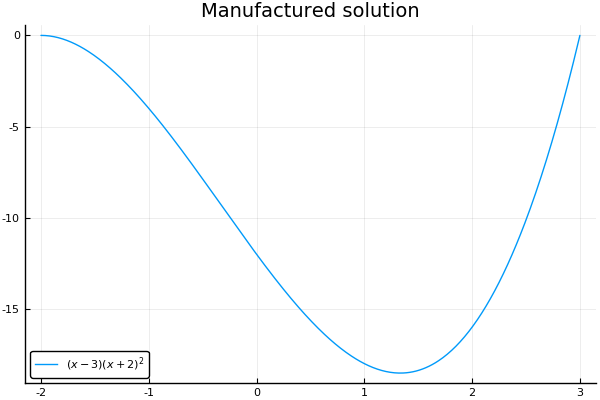

In [5]:
u_ref(x) = (x-3)*(x+2)^2
interval = -2:0.01:3
plot(u_ref, interval, title="Manufactured solution", label = "\$(x-3)(x+2)^2\$")

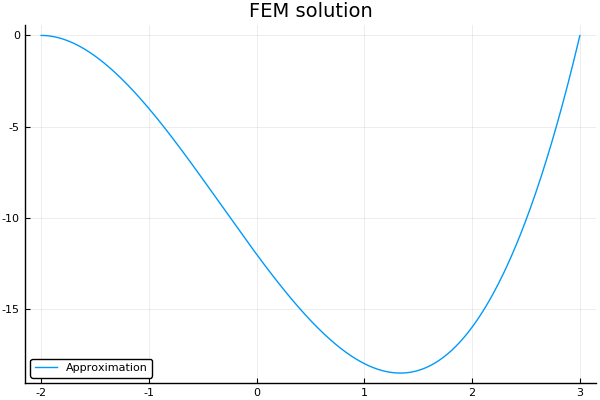

In [6]:
f(x) = -6x - 2
sol = fem_1d(f, interval);
plot(interval, sol, title="FEM solution", label="Approximation")

In [7]:
println("Error = $(norm(sol.-u_ref.(interval)))")

Error = 1.1601579726125756e-9


#### **Convergence**

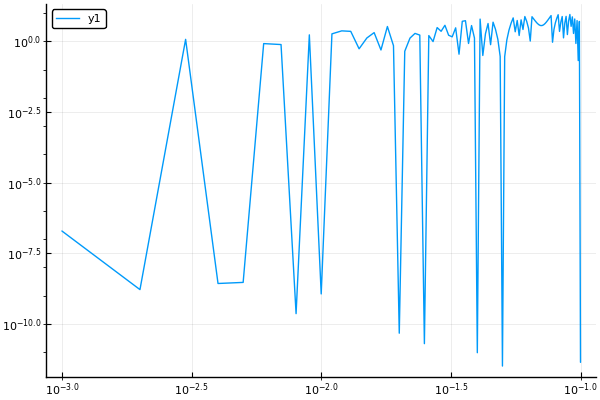

In [8]:
steps = 0.1:-0.001:0.001
errors = zeros(length(steps))
for (i, h) = enumerate(steps)
    interval = -2:h:3
    sol = fem_1d(f, interval)
    errors[i] = norm(sol.-u_ref.(interval))
end
plot(steps, errors, xscale = :log10, yscale = :log10)

I unfortunately didn't have time to test the 2d solution.

# **Discussion**

The 1d method worked as expected; unfortunately I wasn't able to test out the 2d version.

# **References**

- Hoffman, J. 2019. *Introduction to Scientific Computing*